# Notes for Stanford CS143 Compilers

## Week 08: Local Optimization & Global Optimization

### Intermediate Code

 A language between the source and the target
• Provides an intermediate level of abstraction – More details than the source
– Fewer details than the target

Intermediate language = high-level assembly
– Uses register names, but has an unlimited number – Uses control structures like assembly language
– Uses opcodes but some are higher level
• E.g., push translates to several assembly instructions
• Most opcodes correspond directly to assembly opcodes

Each instruction is of the form x := y op z
x := op y
– y and z are registers or constants
– Common form of intermediate code
• The expression x + y * z is translated
t1 := y * z
t2 := x + t1
– Each subexpression has a “name”

• Similar to assembly code generation
• But use any number of IL registers to hold intermediate results

igen(e,t)
– code to compute the value of e in register t
• Example:
igen(e1 + e2, t) =
igen(e1, t1) (t1 is a fresh register) igen(e2, t2) (t2 is a fresh register) t:=t1 +t2
• Unlimited number of registers => simple code generation

 You should be able to use intermediate code – At the level discussed in lectures
• You are not expected to know how to generate intermediate code
– Because we won’t discuss it further
– But really just a variation on code generation . . .

### Optimization Overview

Optimizationisourlastcompilerphase
• Most complexity in modern compilers is in the
optimizer
– Also by far the largest phase

When should we perform optimizations?
– On AST
• Pro: Machine independent • Con:Toohighlevel
– On assembly language
• Pro: Exposes optimization opportunities
• Con:Machinedependent
• Con: Must reimplement optimizations when retargetting
– On an intermediate language
• Pro: Machine independent
• Pro: Exposes optimization opportunities

Id’s are register names
• Constants can replace id’s
• Typical operators: +, -, *


• A basic block is a maximal sequence of instructions with: – no labels (except at the first instruction), and
– no jumps (except in the last instruction)
• Idea:
– Cannot jump into a basic block (except at beginning)
– Cannot jump out of a basic block (except at end)
– A basic block is a single-entry, single-exit, straight-line code segment

Consider the basic block
1. L:
2. t := 2 * x
3. w := t + x
4. if w > 0 goto L’
(3) executes only after (2)
– We can change (3) to w := 3 * x
– Can we eliminate (2) as well?

• A control-flow graph is a directed graph with
– Basic blocks as nodes
– An edge from block A to block B if the execution can pass from the last instruction in A to the first instruction in B
• E.g., the last instruction in A is jump LB
• E.g., execution can fall-through from block A to block B

• The body of a method (or procedure) can be represented as a control-flow graph
• There is one initial node
• All “return” nodes are terminal

•
For languages like C and Cool there are three granularities of optimizations
1. Local optimizations
• Apply to a basic block in isolation
2. Global optimizations
• Apply to a control-flow graph (method body) in isolation
3. Inter-procedural optimizations • Apply across method boundaries
Most compilers do (1), many do (2), few do (3)

In practice, often a conscious decision is made not to implement the fanciest optimization known
• Why?
– Some optimizations are hard to implement
– Some optimizations are costly in compilation time – Some optimizations have low payoff
– Many fancy optimizations are all three!
• Goal: Maximum benefit for minimum cost

### Local Optimization

• Optimizeonebasicblock
• No need to analyze the whole procedure body

Some statements can be deleted x := x + 0
x := x * 1
• Some statements can be simplified
x := x * 0 y := y ** 2 x := x * 8 x := x * 15
 x := 0
 y := y * y
 x := x << 3
 t := x << 4; x := t - x
(on some machines << is faster than *; but not on all!)

Operations on constants can be computed at compile time
– If there is a statement x := y op z
– And y and z are constants
– Then y op z can be computed at compile time
• Example: x := 2 + 2  x := 4
• Example: if 2 < 0 jump L can be deleted

• Constant folding can be dangerous.
cross-compiling

• Eliminate unreachable basic blocks:
– Code that is unreachable from the initial block
• E.g., basic blocks that are not the target of any jump or “fall through” from a conditional
• Removing unreachable code makes the program smaller
– And sometimes also faster
• Due to memory cache effects • Increased spatial locality

• Why would unreachable basic blocks occur?
if(debug)


• Some optimizations are simplified if each register occurs only once on the left-hand side of an assignment
• Rewrite intermediate code in single assignment form
x := z + y a := x
x := 2 * x
b := z + y  a := b
x := 2 * b (b is a fresh register)
– More complicated in general, due to loops

If
– Basic block is in single assignment form
– A definition x := is the first use of x in a block
• Then
– When two assignments have the same rhs, they compute
the same value
• Example:
x := y + z x := y + z ......
w := y + z w := x
(the values of x, y, and z do not change in the ... code)

If w := x appears in a block, replace subsequent uses of w with uses of x
– Assumessingleassignmentform
• Example:
b := z + y
a := b
x := 2 * a
b := z + y  a := b
x := 2 * b
• Only useful for enabling other optimizations – Constantfolding
– Deadcodeelimination

 Example: a := 5
x := 2 * a  y := x + 6
t := x * y
a := 5
x := 10
y := 16
t := x << 4

 If
w does not appear anywhere else in the program Then
the statement w := rhs is dead and can be eliminated
– Dead = does not contribute to the program’s result Example: (a is not used anywhere else)
w := rhs appears in a basic block
x := z + y
a := x  x := 2 * a
b := z + y b := z + y
a := b  x := 2 * 

• Each local optimization does little by itself
• Typically optimizations interact
– Performing one optimization enables another
• Optimizing compilers repeat optimizations until no
improvement is possible
– The optimizer can also be stopped at any point to limit compilation time

Initial code:
a := x ** 2
b := 3
c := x
d := c * c e := b * 2 f := a + d g := e * f

Algebraicoptimization: a := x ** 2
b := 3
c := x
d := c * c e := b * 2 f := a + d g := e * f

Algebraicoptimization: a := x * x
b := 3
c := x
d := c * c e := b << 1 f := a + d
g := e * f

Copy propagation: a := x * x
b := 3
c := x
d := c * c e := b << 1 f := a + d
g := e * f

Copy propagation: a := x * x
b := 3
c := x
d := x * x e := 3 << 1 f := a + d
g := e * f

Constantfolding: a := x * x
b := 3
c := x
d := x * x e := 3 << 1 f := a + d
g := e * f

• Constantfolding: a := x * x
b := 3
c := x
d := x * x e := 6
f := a + d g := e * f

 Commonsubexpressionelimination: a := x * x
b := 3
c := x
d := x * x e := 6
f := a + d g := e * f

Commonsubexpressionelimination: a := x * x
b := 3
c := x
d := a
e := 6
f := a + d g := e * f

 Copy propagation: a := x * x
b := 3
c := x
d := a
e := 6
f := a + d g := e * f

Copy propagation: a := x * x
b := 3
c := x
d := a
e := 6
f := a + a g := 6 * f

Dead code elimination: a := x * x
b := 3
c := x
d := a
e := 6
f := a + a g := 6 * f

Dead code elimination: a := x * x
f := a + a g := 6 * f
• This is the final form

### Peephole Optimization

• Optimizations can be directly applied to assembly code
• Peephole optimization is effective for improving assembly code
– The “peephole” is a short sequence of (usually contiguous) instructions
– The optimizer replaces the sequence with another equivalent one (but faster)

Write peephole optimizations as replacement rules i1, ..., in  j1, ..., jm
where the rhs is the improved version of the lhs
• Example:
move $a $b, move $b $a  move $a $b
– Works if move $b $a is not the target of a jump
• Another example
addiu $a $a i, addiu $a $a j  addiu $a $a i+j

Many (but not all) of the basic block optimizations can be cast as peephole optimizations
– Example: addiu $a $b 0  move $a $b
– Example: move $a $a 
– These two together eliminate addiu $a $a 0
• As for local optimizations, peephole optimizations must be applied repeatedly for maximum effect

• Many simple optimizations can still be applied on assembly language
• “Program optimization” is grossly misnamed
– Code produced by “optimizers” is not optimal in any reasonable sense – “Program improvement” is a more appropriate term
  

### 15 Dataflow Analysis

 Recall the simple basic-block optimizations
– Constant propagation – Dead code elimination




## Week 09: Register Allocation & Garbage Collection



## Week 10: Java

/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Applications/Pineapple.app/Contents/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


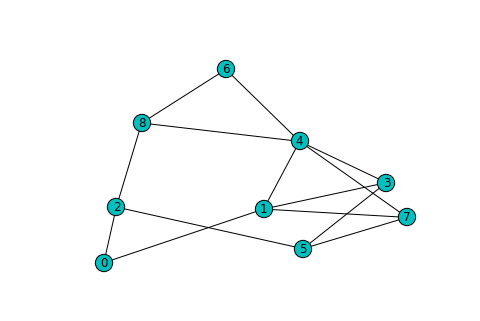

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
G=nx.Graph()#  G is an empty Graph
Nodes=range(9)
G.add_nodes_from(Nodes)
Edges=[(0,1), (0,2), (1,3), (1,4), (1,7), (2,5), (2,8), (3, 4), (3,5),(4,6), (4,7), (4,8), (5,7)]
G.add_edges_from(Edges)
G.add_edge(6,8)
nx.draw(G, node_color='c',edge_color='k', with_labels=True)